In [10]:
%qtconsole

In [1]:
## Import modules
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss
import pyscenic.transform
import pyscenic.export

from IPython.display import HTML, display

In [2]:
## Update derive_regulons function to reflect database used
## Also: odd issue where function is not found sometimes? Better to just create it directly
def derive_regulons(motifs, db_names=('hg19__refseq-r80__500bp_up_and_100bp_down_tss.genes_vs_motifs.rankings', 
                                 'hg19__refseq-r80__10kb_up_and_100bp_down_tss.genes_vs_motifs.rankings')):
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                        | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                           & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))

## Run last steps of SCENIC (Steps 1-3 run on O2)

### Settings + file locations

In [22]:
## Input/output directory
RESULTS_FOLDERNAME = "analysis/"
FIGURES_FOLDERNAME = "figures/"

## Set analysis name- just used for saving output
ANALYSIS_NAME = "Myeloid"

## File names for reading in/exporting
MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, 'step2_output/{}_scenic_step2_output.csv'.format(ANALYSIS_NAME))
REGULONS_DAT_FNAME = os.path.join(RESULTS_FOLDERNAME, 'regulons_{}.dat'.format(ANALYSIS_NAME))
AUCELL_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, 'auc_{}.csv'.format(ANALYSIS_NAME))
BIN_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, 'bin_{}.csv'.format(ANALYSIS_NAME))
THR_FNAME = os.path.join(RESULTS_FOLDERNAME, 'thresholds_{}.csv'.format(ANALYSIS_NAME))
ANNDATA_FNAME = os.path.join(RESULTS_FOLDERNAME, 'Anndata_{}.h5ad'.format(ANALYSIS_NAME))
EXP_MTX_QC_FNAME = os.path.join(RESULTS_FOLDERNAME, 'input/{}_tpm.csv'.format(ANALYSIS_NAME))
CELL_ANNOTATIONS_FNAME = os.path.join(RESULTS_FOLDERNAME, 'input/{}_cell.annotations.csv'.format(ANALYSIS_NAME))
REGULONS_ZSCORES=os.path.join(RESULTS_FOLDERNAME, '{}_regulon_zscores.csv'.format(ANALYSIS_NAME))

### Load in motifs (from Step 2-3, on O2)

In [23]:
## Load in motifs (from step 2-3, O2)
df_motifs=load_motifs(RESULTS_FOLDERNAME+'step2_output/{}_scenic_step2_output.csv'.format(ANALYSIS_NAME))

### STEP 4: Cellular enrichment aka AUCell

__REGULON CREATION__

Regulons can easily be created from this list of enriched motifs via `pyscenic.transform.df2regulons`. Here we provide an auxilliary function to carefully select the enriched motifs that contribute to the regulons.

In [24]:
regulons = derive_regulons(df_motifs)

# Pickle these regulons.
with open(REGULONS_DAT_FNAME, 'wb') as f:
    pickle.dump(regulons, f)

/var/folders/0g/x0qxvlnj72s5n8p_mqnm5yfr0000gp/T/ipykernel_71763/3647503236.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
/var/folders/0g/x0qxvlnj72s5n8p_mqnm5yfr0000gp/T/ipykernel_71763/3647503236.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecation

Create regulons from a dataframe of enriched features.
Additional columns saved: []


__AUCELL__

In [25]:
## Read in matrix/metadata for use below
df_tpm = pd.read_csv(EXP_MTX_QC_FNAME, index_col=0)
df_metadata = pd.read_csv(CELL_ANNOTATIONS_FNAME)

In [26]:
%%time

## Run AUCELL
auc_mtx = aucell(df_tpm, regulons, num_workers=26)
auc_mtx.to_csv(AUCELL_MTX_FNAME)

CPU times: user 2.92 s, sys: 1.5 s, total: 4.41 s
Wall time: 36.4 s


In [27]:
## Quick check of aucell results
auc_mtx = pd.read_csv(AUCELL_MTX_FNAME, index_col=0)
auc_mtx.head()

,ALX3,ALX4,ASCL2,ATF3,ATF4,BACH2,BCL11A,BHLHE40,CEBPB,CEBPD,...,ZNF775,ZNF787,ZNF80,ZNF814,ZNF836,ZNF879,ZNF90,ZSCAN16,ZSCAN20,ZSCAN4
Cell,,,,,,,,,,,,,,,,,,,,,
BT1187.P1.A03,0.0,0.0,0.002370,0.071678,0.221543,0.000000,0.076812,0.052151,0.105556,0.054632,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.025777,0.020643,0.009098
BT1187.P1.A04,0.0,0.0,0.042606,0.113102,0.239748,0.028100,0.100077,0.167262,0.107662,0.064167,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00642,0.000000,0.000000,0.009113
BT1187.P1.A07,0.0,0.0,0.001430,0.243107,0.260684,0.002713,0.048224,0.071826,0.130803,0.144187,...,0.0,0.011009,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000
BT1187.P1.A08,0.0,0.0,0.000000,0.081955,0.236519,0.008850,0.076623,0.071698,0.092618,0.062966,...,0.0,0.000000,0.0,0.032925,0.0,0.0,0.00000,0.037026,0.000000,0.000000
BT1187.P1.A09,0.0,0.0,0.001541,0.225756,0.303555,0.000000,0.061844,0.055473,0.108263,0.130468,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.031907,0.000000,0.000000


In [30]:
## Binarize the auc values (on/off)
bin_mtx, thresholds = binarize(auc_mtx)
bin_mtx.to_csv(BIN_MTX_FNAME)
thresholds.to_frame().rename(columns={0:'threshold'}).to_csv(THR_FNAME)

### Create Anndata object

In [28]:
## Make anndata object
adata = sc.AnnData(X=df_tpm.sort_index())
df_obs = df_metadata[['cell_id', 'sample_id', 'cell_type', 'patient_id']].set_index('cell_id').sort_index()
adata.obs = df_obs
adata.var_names_make_unique()

# Store non-log transformed data as raw. This data can be used via the use_raw parameters available for many functions.
# In the scanpy's tutorials this is used to stored all genes in log-transformed counts before retaining only Highly Variable Genes (HVG). 
# Because in this case no filtering is done we use this feature to store raw counts.
adata.raw = adata 
sc.pp.log1p(adata)

add_scenic_metadata(adata, auc_mtx, regulons)
adata.write_h5ad(ANNDATA_FNAME)

... storing 'sample_id' as categorical
... storing 'cell_type' as categorical
... storing 'patient_id' as categorical


### Calculate Z scores for regulons

In [ ]:
## Optional
#df_regulons = pd.DataFrame(data=[list(map(op.attrgetter('name'), regulons)),
                             #    list(map(len, regulons)),
                               #  list(map(fetch_logo, regulons))], index=['name', 'count', 'logo']).T

In [29]:
df_obs = adata.obs

## Calculate zscore
signature_column_names = list(df_obs.select_dtypes('number').columns)
signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
df_scores = df_obs[signature_column_names + ['cell_type']]
df_results = ((df_scores.groupby(by='cell_type').mean() - df_obs[signature_column_names].mean())/ df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
df_results[(df_results.Z >= 0)].sort_values('Z', ascending=False).head()


df_results.to_csv(REGULONS_ZSCORES)

# Everything beneath here optional- plotting, etc.
### Final downstream plotting in R

## Plot results

This code comes from the SCENIC tutorial. Alternatively, can load the data into R and plot there

/Users/jlabelle/opt/anaconda3/envs/pysenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jlabelle/opt/anaconda3/envs/pysenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jlabelle/opt/anaconda3/envs/pysenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

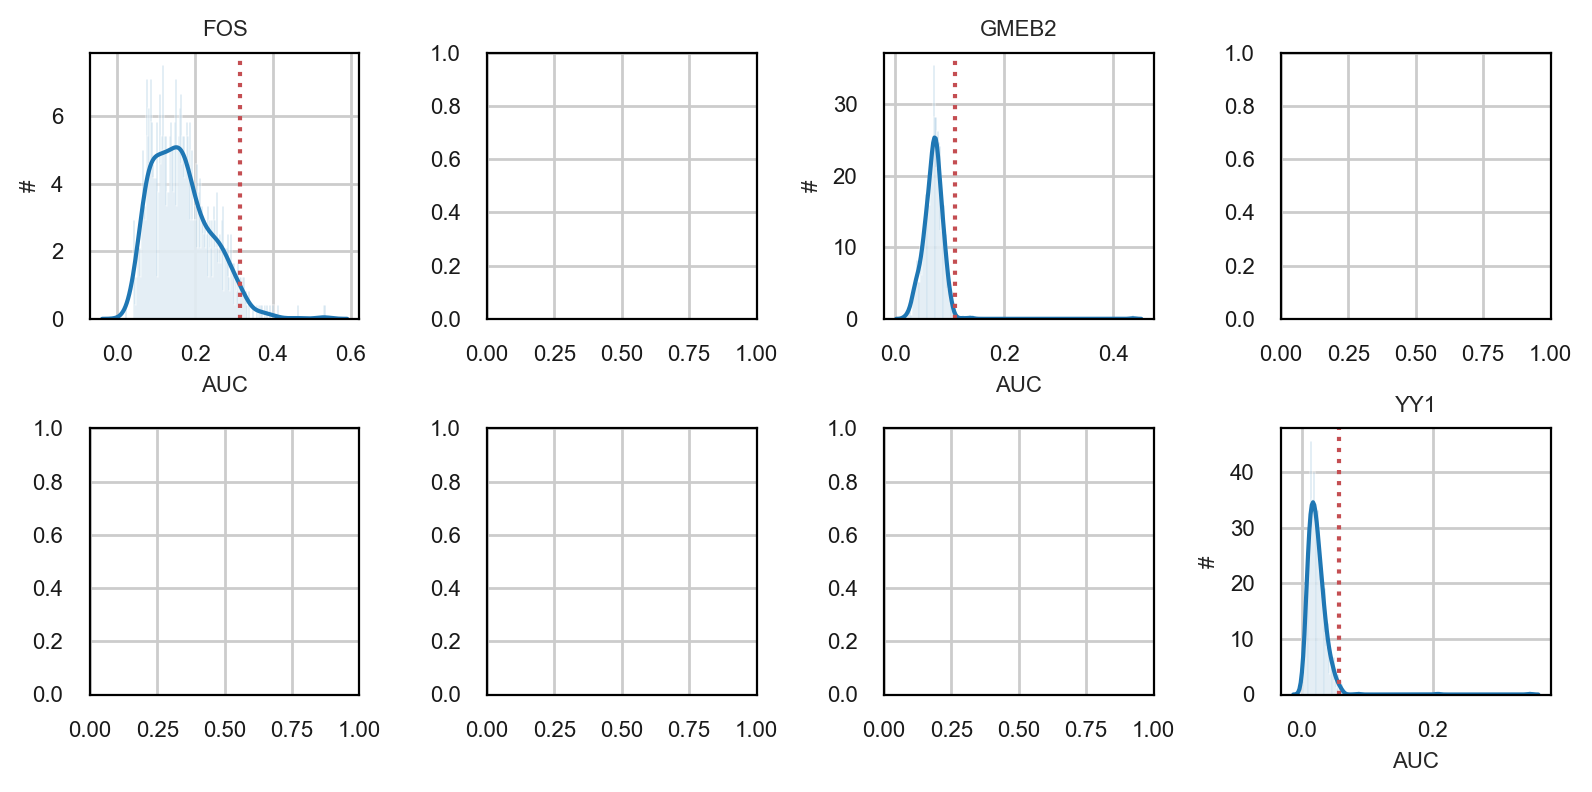

In [258]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(8, 4), dpi=100)

plot_binarization(auc_mtx, 'FOS', thresholds['FOS'], ax=ax1)
#plot_binarization(auc_mtx, 'CRX', thresholds['CRX'], ax=ax2)
plot_binarization(auc_mtx, 'GMEB2', thresholds['GMEB2'], ax=ax3)
#plot_binarization(auc_mtx, 'PAX5', thresholds['PAX5'], ax=ax4)
#plot_binarization(auc_mtx, 'IRF8', thresholds['IRF8'], ax=ax5)
#plot_binarization(auc_mtx, 'IRF3', thresholds['IRF3'], ax=ax6)
#plot_binarization(auc_mtx, 'MLX', thresholds['MLX'], ax=ax7)
plot_binarization(auc_mtx, 'YY1', thresholds['YY1'], ax=ax8)

plt.tight_layout()
fig_name=["hists", ANALYSIS_NAME, "binarization.svg"]
savesvg("_".join(fig_name), fig)

In [260]:
N_COLORS = len(df_metadata["cell_type"].unique())
COLORS = [color['color'] for color in mpl.rcParams["axes.prop_cycle"]]

In [262]:
cell_type_color_lut = dict(zip(df_metadata["cell_type"].unique(), COLORS))
#cell_type_color_lut = dict(zip(adata.obs.cell_type.dtype.categories, adata.uns['cell_type_colors']))
#cell_id2cell_type_lut = df_metadata.set_index('cell_id').cell_type.to_dict()
bw_palette = sns.xkcd_palette(["white", "black"])

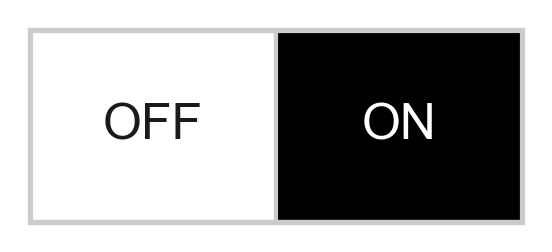

In [264]:
sns.set()
sns.set_style("whitegrid")
fig = palplot(bw_palette, ['OFF', 'ON'], ['k', 'w'])
savesvg('legend - GSE115978 - on_off.svg', fig)

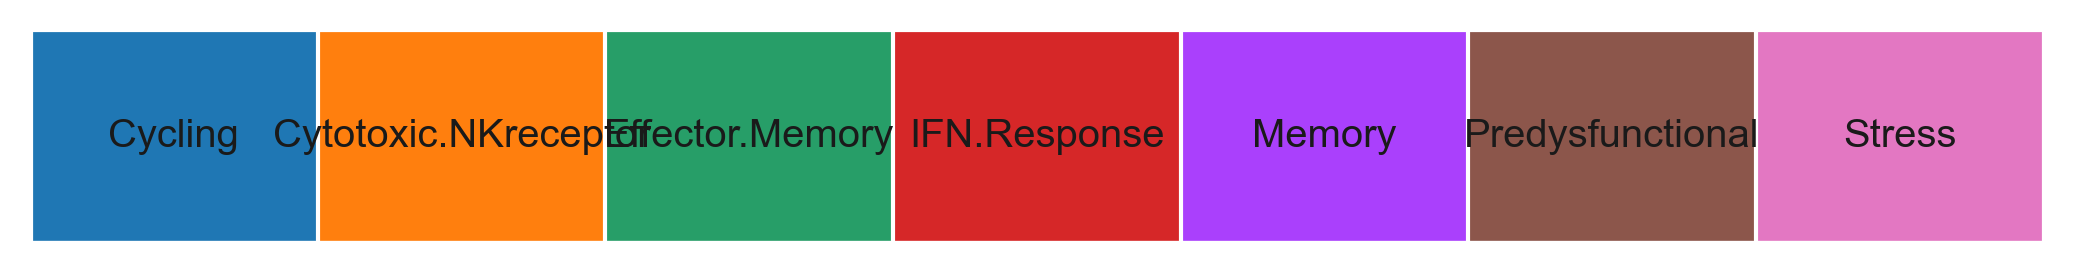

In [265]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot(sns.color_palette(COLORS)[0:N_COLORS], adata.obs.cell_type.dtype.categories, size=1.0)

fig_name=["legend", ANALYSIS_NAME, "cell_type_colors.svg"]
savesvg("_".join(fig_name), fig)


In [267]:
MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
display(HTML(df_regulons.head().to_html(escape=False)))
pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

/Users/jlabelle/opt/anaconda3/envs/pysenic/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,name,count,logo
0,ARGFX,22,
1,ATF1,61,
2,ATF3,17,
3,ATF6,28,
4,BCL11A,12,


In [268]:
sns.set()

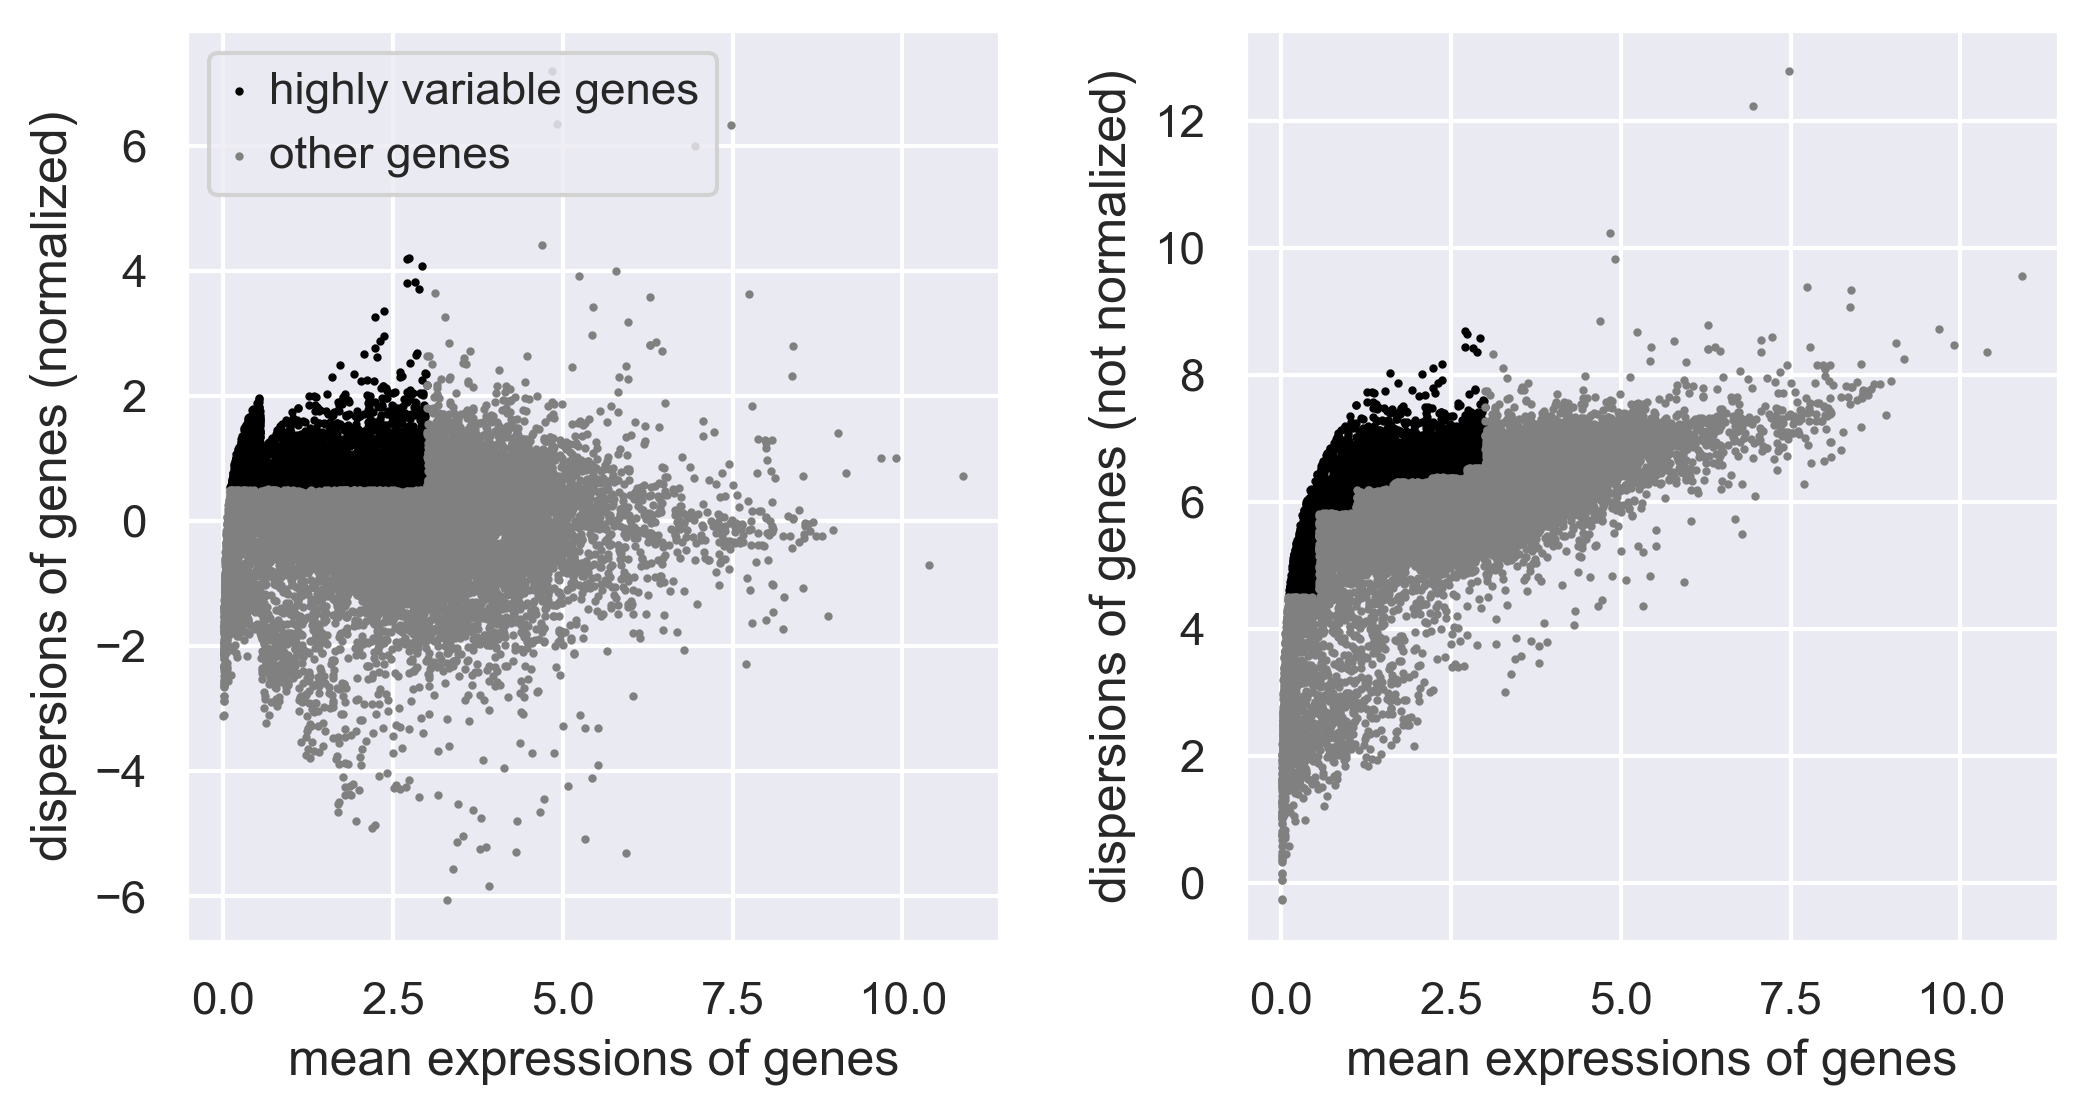

In [270]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]

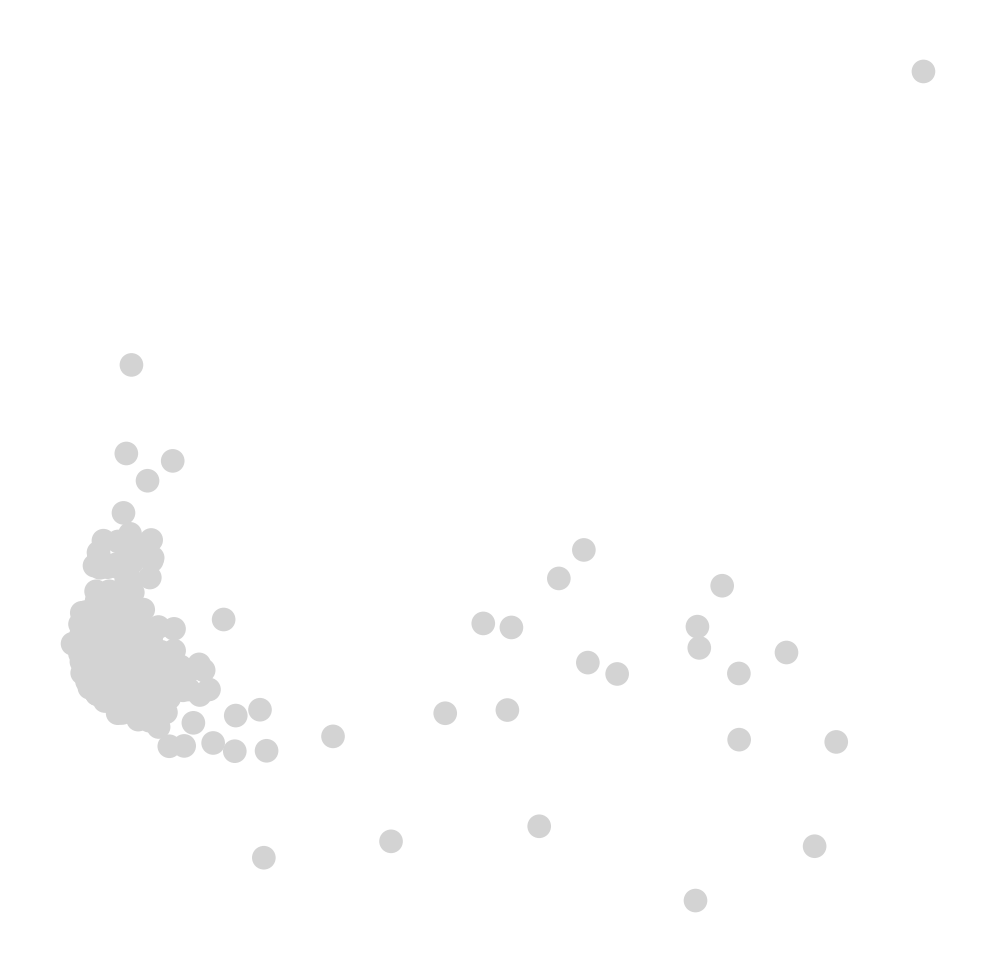

In [272]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

In [274]:
sc.tl.tsne(adata)

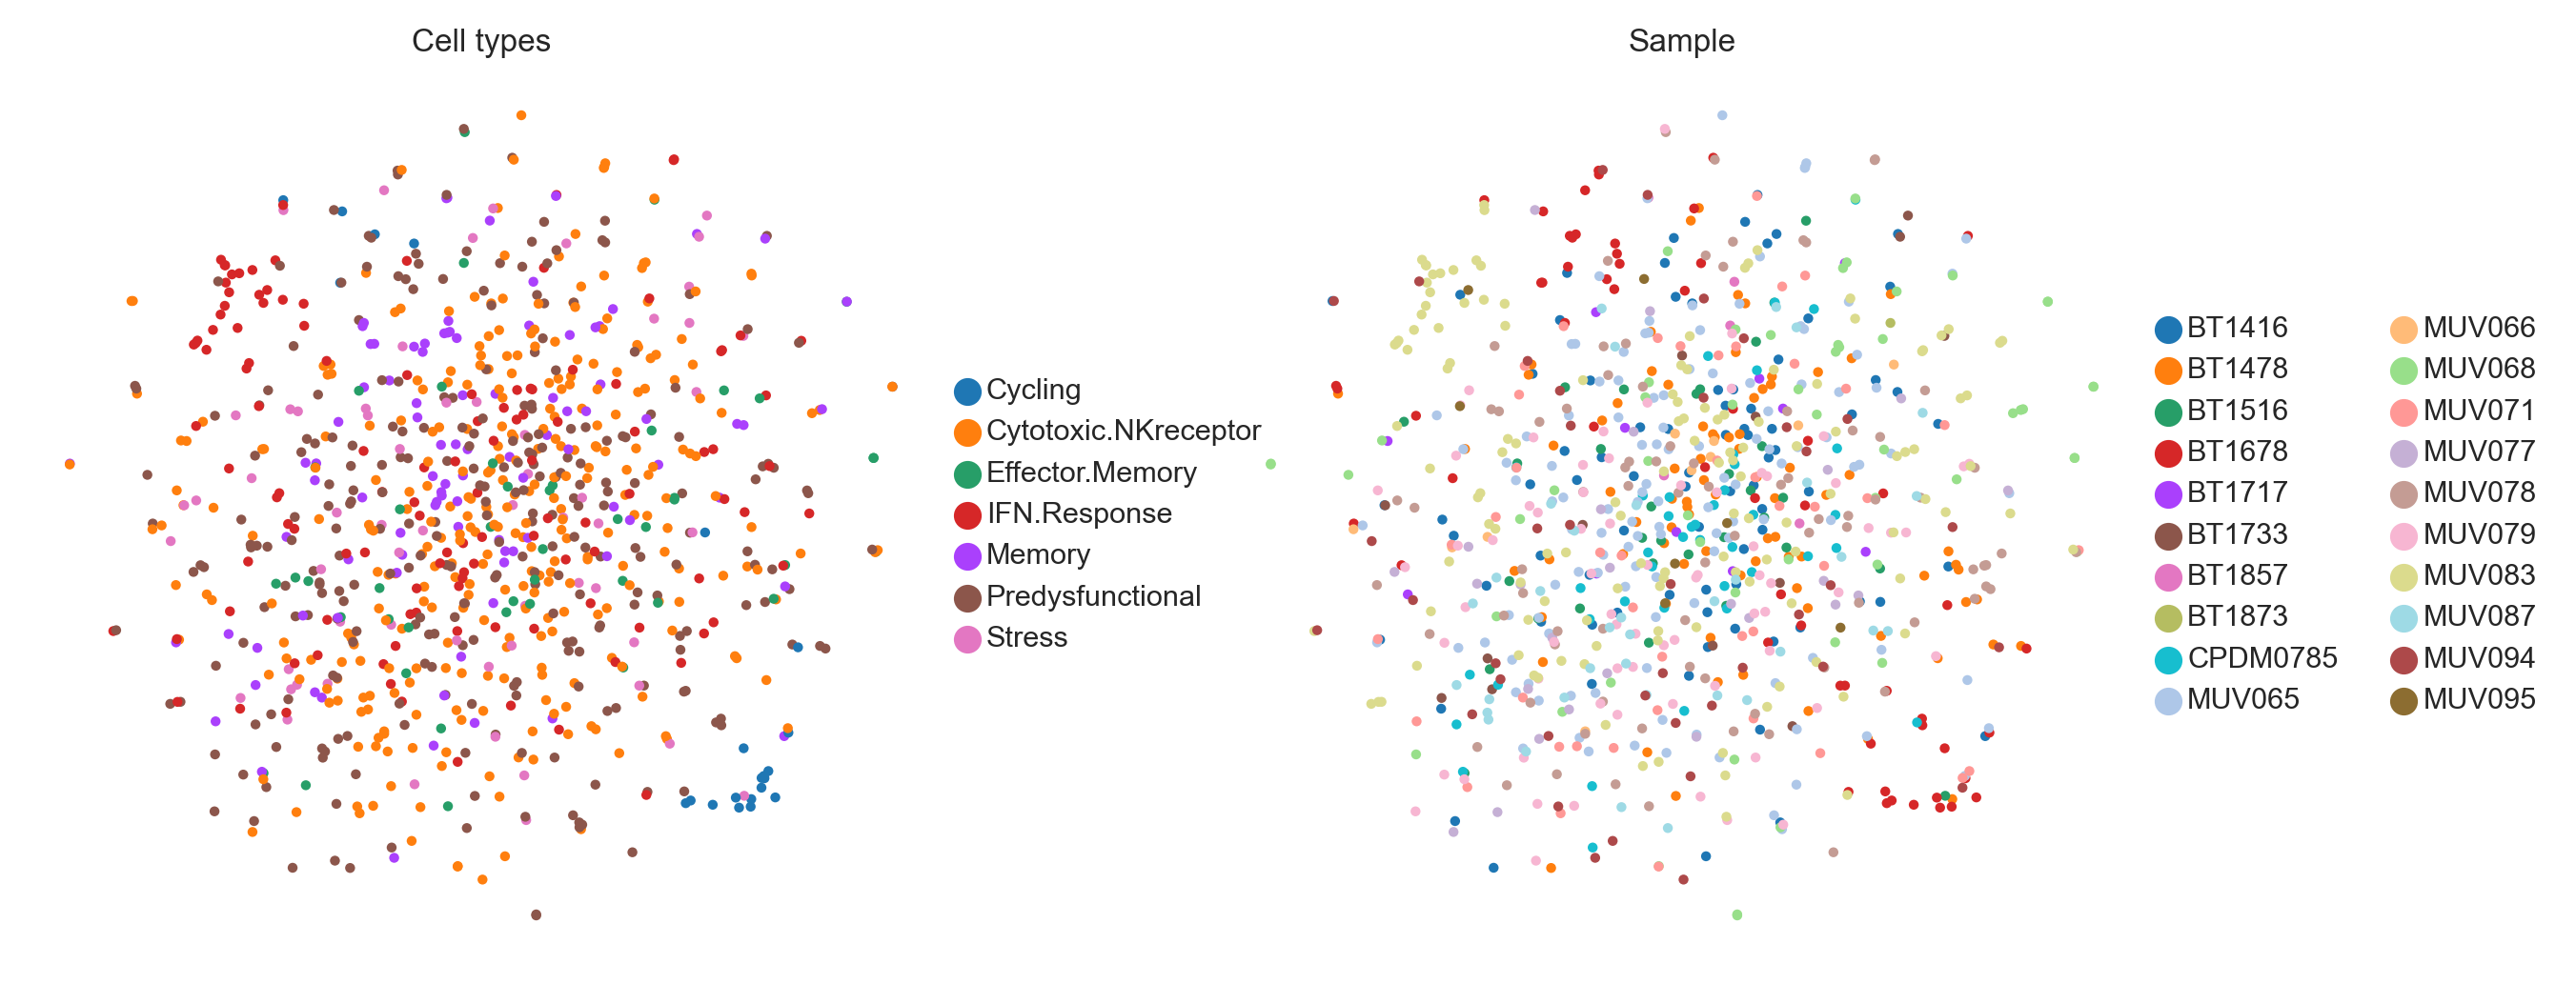

In [276]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
fig_name=["tSNEPCA", ANALYSIS_NAME, ".svg"]

sc.pl.tsne(adata, color=['cell_type', 'patient_id'], size=25,
           title=['Cell types', 'Sample',
                 'GSE115978 - SKCM - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=3, palette=COLORS,
          save="_".join(fig_name))

In [278]:
embedding_pca_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)
add_scenic_metadata(adata, auc_mtx, regulons)
adata.write_h5ad(ANNDATA_FNAME)

In [279]:
adata.obs

,sample_id,cell_type,patient_id,Regulon(ARGFX),Regulon(ATF1),Regulon(ATF3),Regulon(ATF6),Regulon(BCL11A),Regulon(BHLHE40),Regulon(BHLHE41),...,Regulon(ZNF76),Regulon(ZNF761),Regulon(ZNF768),Regulon(ZNF770),Regulon(ZNF771),Regulon(ZNF782),Regulon(ZNF785),Regulon(ZNF835),Regulon(ZNF845),Regulon(ZSCAN4)
cell_id,,,,,,,,,,,,,,,,,,,,,
BT1416CD3_P1_A03,BT1416,Memory,BT1416,0.206442,0.161388,0.000000,0.000000,0.000000,0.016275,0.034483,...,0.018110,0.027800,0.197256,0.0,0.024752,0.000000,0.028968,0.000000,0.000000,0.0000
BT1416CD3_P1_A05,BT1416,Predysfunctional,BT1416,0.243857,0.122710,0.020683,0.016086,0.000000,0.004321,0.002753,...,0.035473,0.027771,0.000000,0.0,0.000000,0.173617,0.000000,0.000000,0.000000,0.0184
BT1416CD3_P1_A06,BT1416,Cytotoxic.NKreceptor,BT1416,0.207782,0.126633,0.070977,0.002370,0.000000,0.118289,0.031043,...,0.027887,0.000000,0.000072,0.0,0.000000,0.061347,0.000000,0.000000,0.000000,0.0000
BT1416CD3_P1_A07,BT1416,IFN.Response,BT1416,0.199673,0.105873,0.017118,0.003820,0.000000,0.159216,0.000000,...,0.014503,0.000000,0.001232,0.0,0.047778,0.000000,0.000135,0.014701,0.006918,0.0000
BT1416CD3_P1_A08,BT1416,Cytotoxic.NKreceptor,BT1416,0.241867,0.122663,0.038960,0.000000,0.000000,0.174035,0.029666,...,0.014404,0.007237,0.240861,0.0,0.000000,0.000000,0.024787,0.000000,0.014506,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MUV095CD45_P8_D06,MUV095,Predysfunctional,MUV095,0.266415,0.138989,0.070023,0.000000,0.000000,0.087446,0.008696,...,0.061707,0.033601,0.008176,0.0,0.000000,0.000000,0.009389,0.013143,0.000000,0.0000
MUV095CD45_P8_F02,MUV095,Predysfunctional,MUV095,0.257956,0.142484,0.040725,0.005007,0.000000,0.139595,0.043811,...,0.033131,0.000000,0.182657,0.0,0.000000,0.000000,0.005612,0.001068,0.002210,0.0000
MUV095CD45_P8_H01,MUV095,IFN.Response,MUV095,0.292182,0.124370,0.000000,0.013376,0.061818,0.170916,0.030813,...,0.028177,0.000000,0.275275,0.0,0.000000,0.106407,0.011989,0.000000,0.000000,0.0000


In [251]:
sc.tl.tsne(adata, use_rep='X_aucell')
embedding_aucell_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)

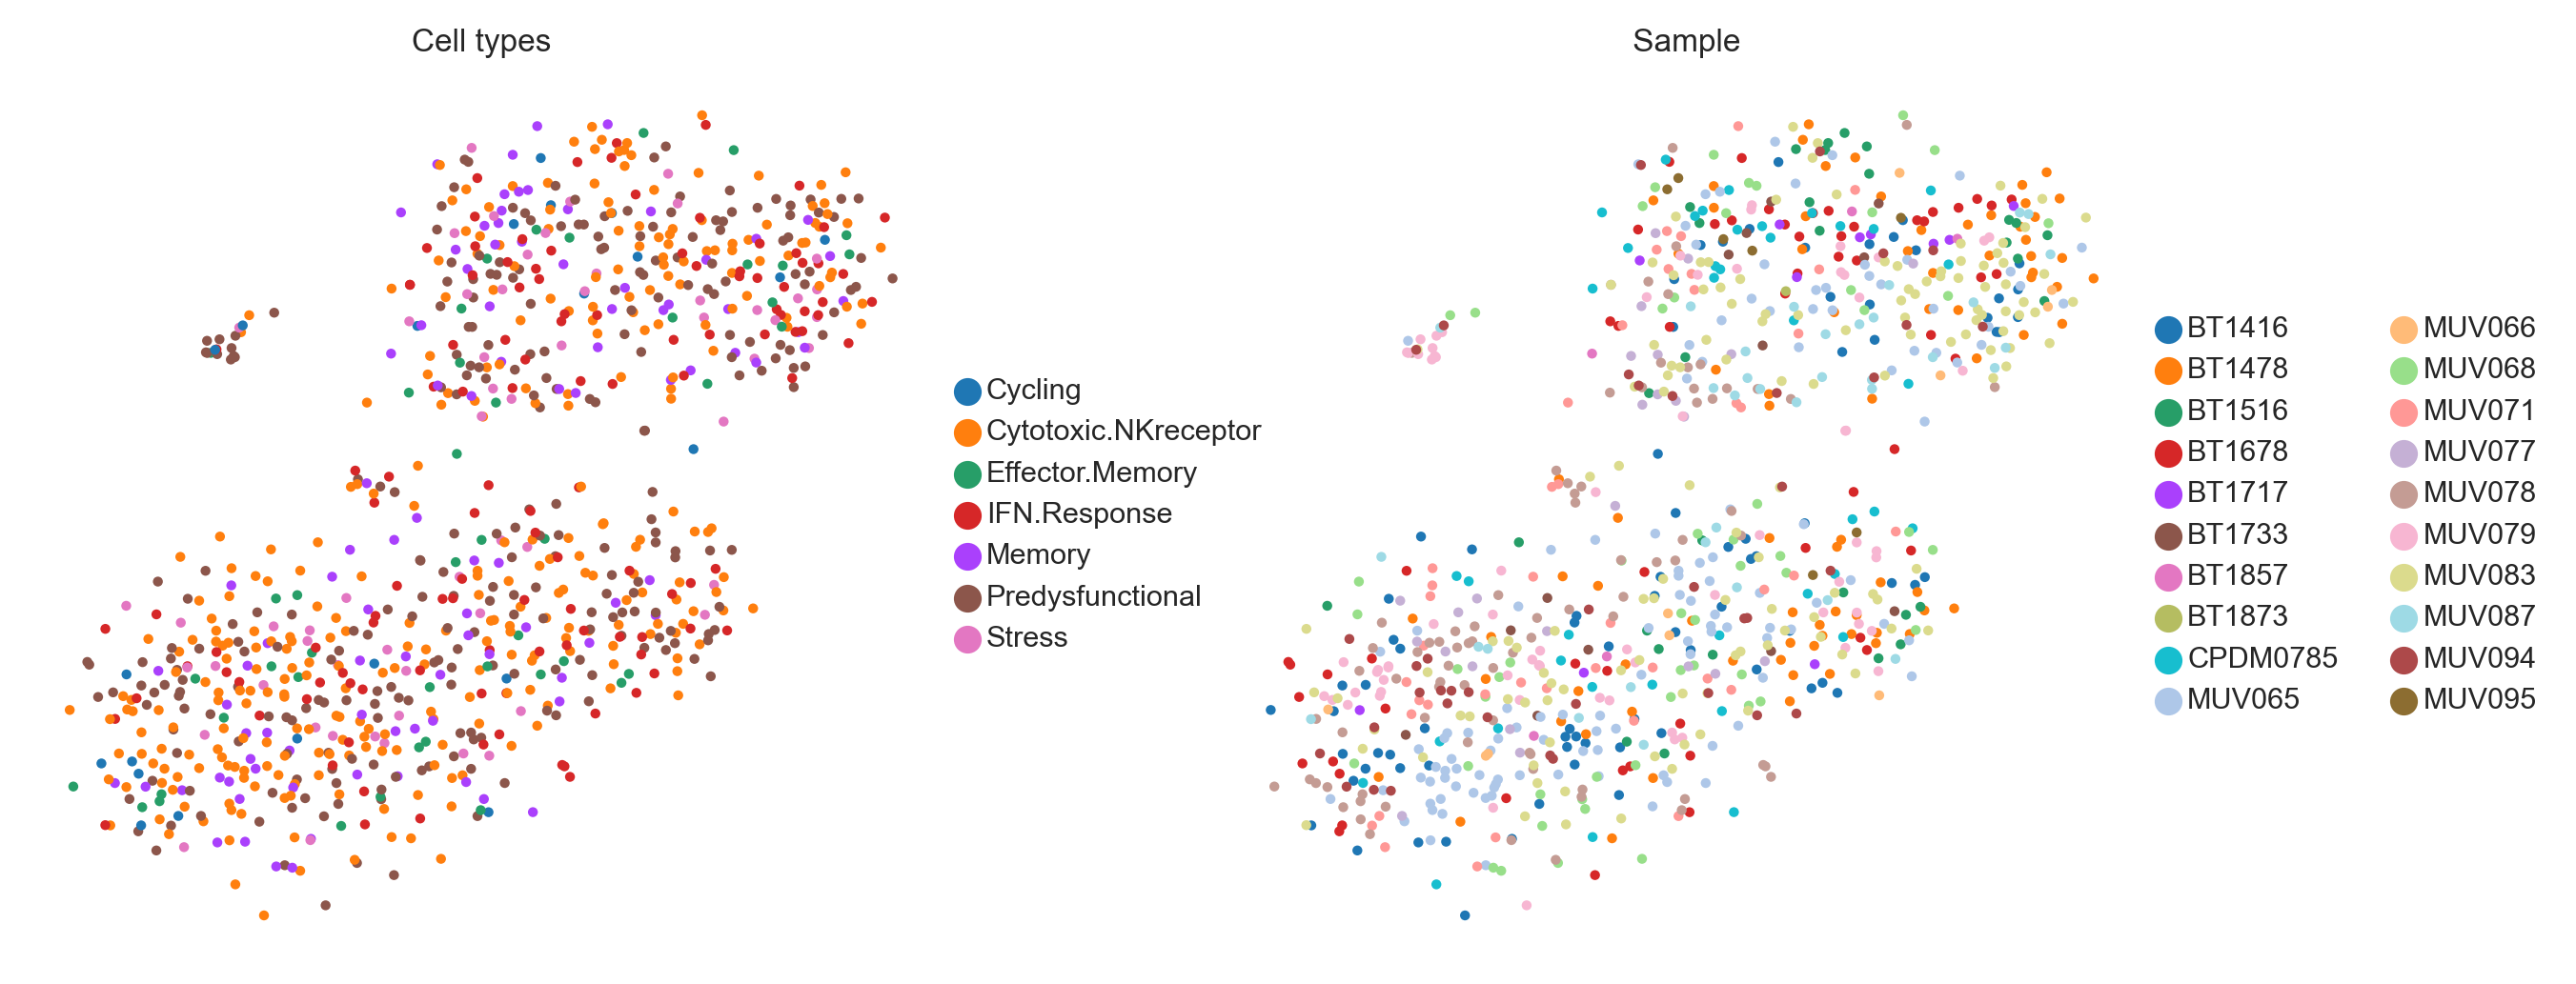

In [252]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)

fig_name=["AUCell_tSNE", ANALYSIS_NAME, ".svg"]
sc.pl.tsne(adata, color=['cell_type',  'patient_id'], size=25,
           title=['Cell types', ' Sample',
                 'GSE115978 - SKCM - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=3, palette=COLORS,
          save="_".join(fig_name))

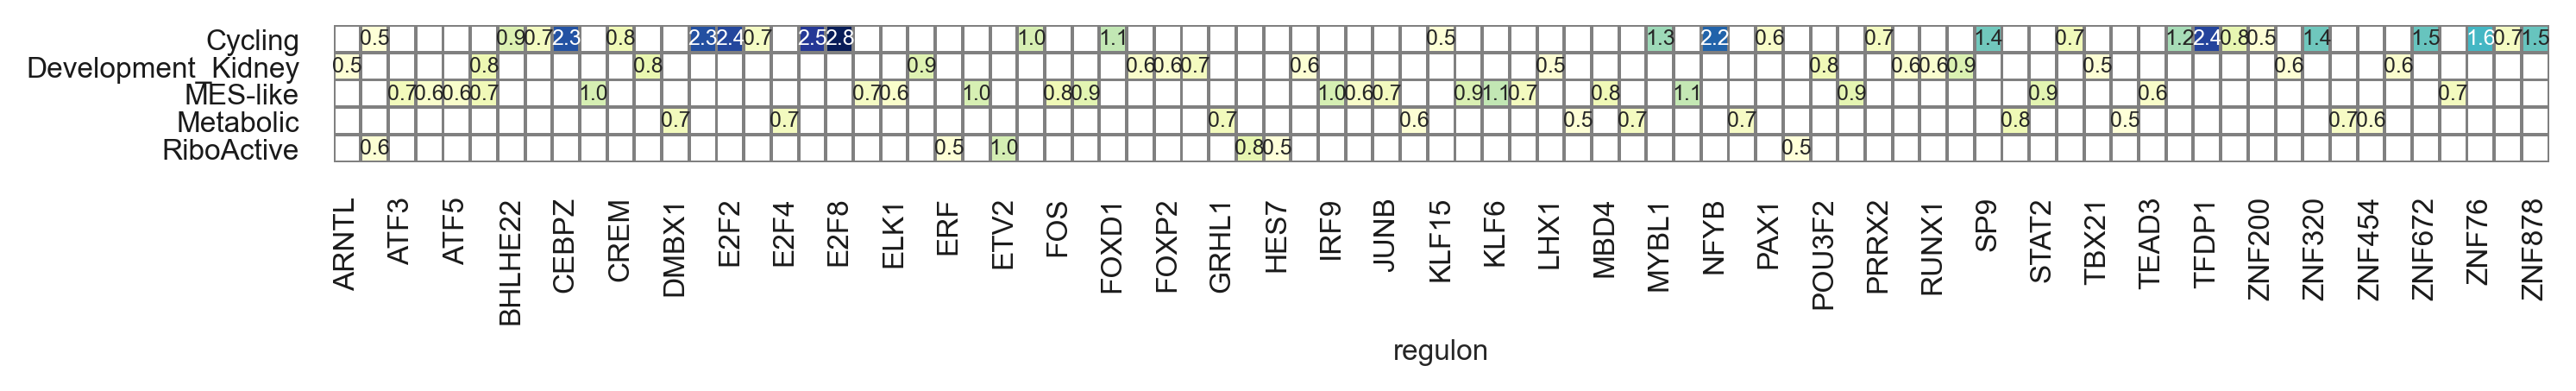

In [111]:
df_heatmap = pd.pivot_table(data=df_results[df_results.Z >= .5].sort_values('Z', ascending=False),
                           index='cell_type', columns='regulon', values='Z')
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 6})
ax1.set_ylabel('')
savesvg('CellSpecific_Regulons_{}.svg'.format(ANALYSIS_NAME), fig)

In [246]:
rss = regulon_specificity_scores(auc_mtx, adata.obs.cell_type)
rss.head()

,AHRR,ARID3A,ARNT,ARNTL,ASCL2,ATF2,ATF3,ATF4,ATF5,BACH1,...,ZNF706,ZNF710,ZNF721,ZNF727,ZNF749,ZNF76,ZNF766,ZNF841,ZNF878,ZSCAN21
RiboActive,0.257029,0.334896,0.198469,0.273293,0.319752,0.259195,0.283864,0.296802,0.298307,0.311995,...,0.261881,0.288112,0.196067,0.247920,0.294321,0.283341,0.226454,0.264232,0.243489,0.282271
Metabolic,0.343625,0.425606,0.258324,0.474724,0.452877,0.469000,0.443300,0.461398,0.459617,0.425317,...,0.443442,0.399688,0.269854,0.444745,0.468898,0.421524,0.420316,0.343080,0.339588,0.449124
Cycling,0.219900,0.292612,0.214093,0.247527,0.279987,0.261941,0.257228,0.263553,0.262942,0.250122,...,0.258681,0.233983,0.206847,0.253057,0.268431,0.336599,0.232743,0.251866,0.430910,0.274923
Development_Kidney,0.259149,0.270072,0.300319,0.347593,0.322848,0.365777,0.351129,0.346588,0.341933,0.320890,...,0.386995,0.293226,0.279787,0.366886,0.336129,0.332145,0.297526,0.290690,0.288110,0.352358
MES-like,0.300450,0.286718,0.281988,0.326217,0.296118,0.314001,0.335145,0.331559,0.333485,0.341909,...,0.323618,0.290622,0.247592,0.292072,0.325411,0.300163,0.281653,0.359655,0.246991,0.308881


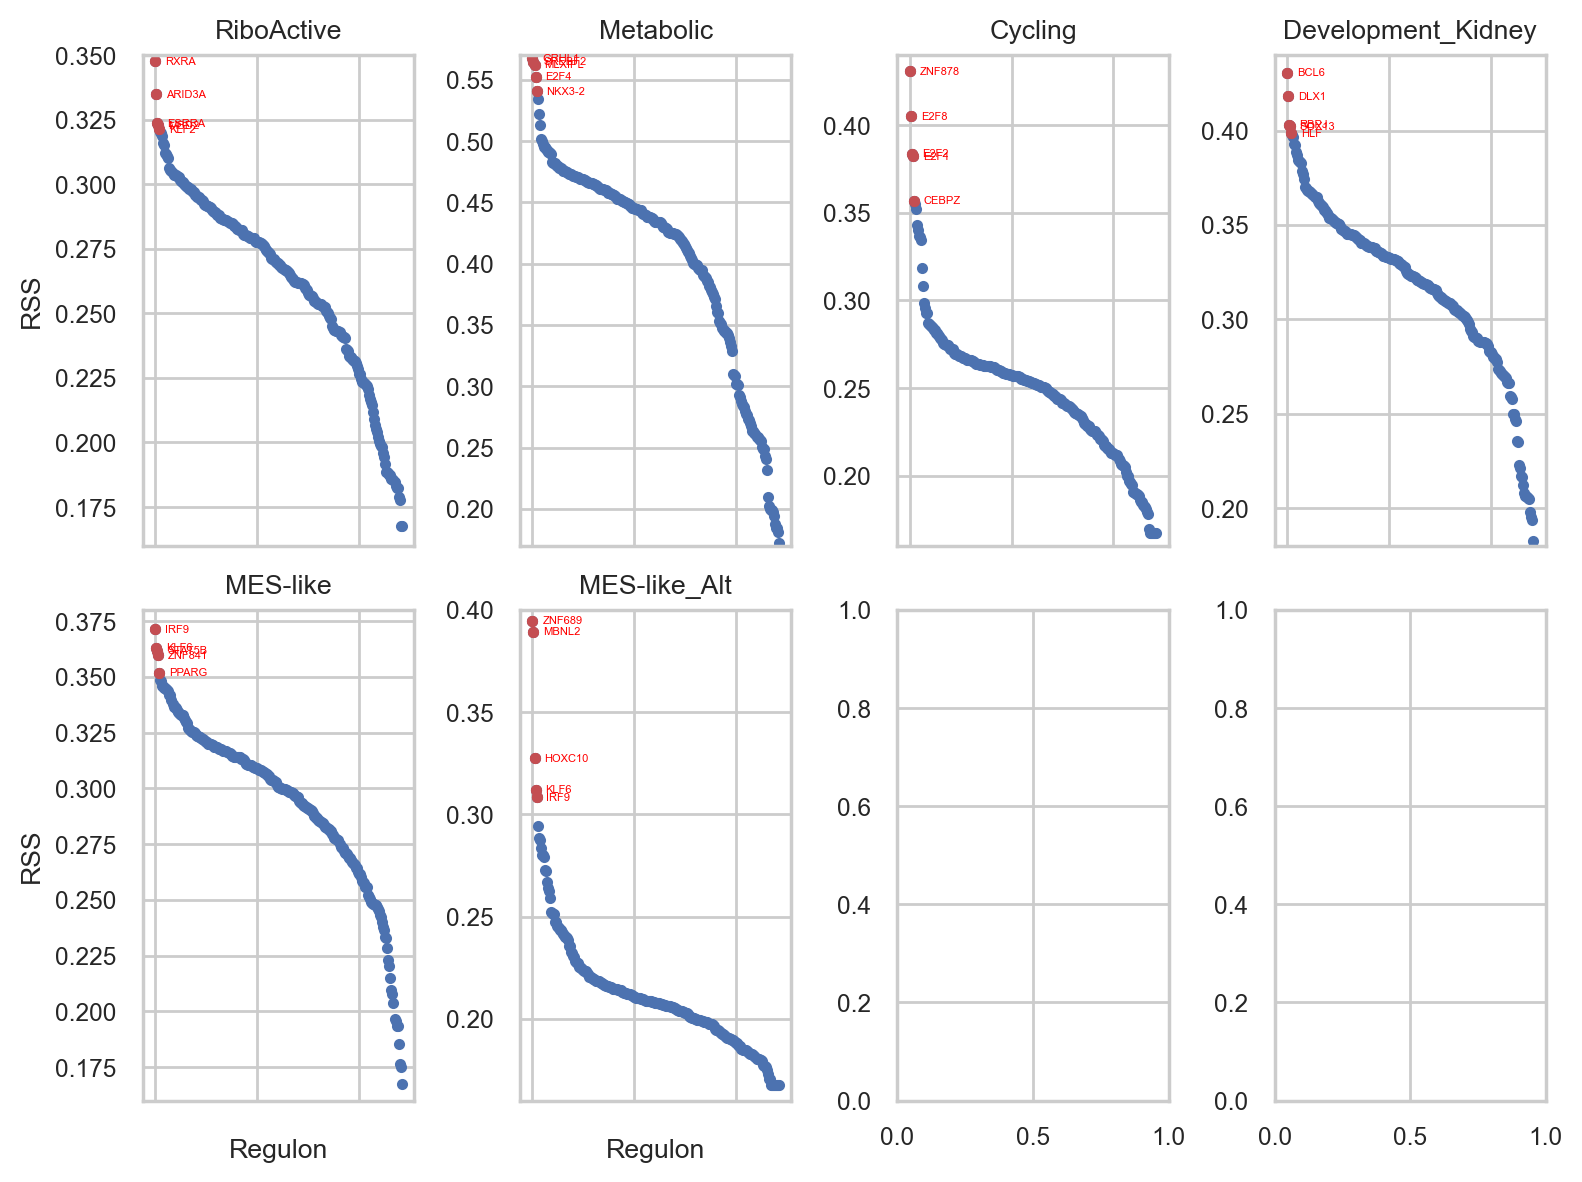

In [247]:
sns.set()
sns.set(style='whitegrid', font_scale=0.8)
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(8, 6), dpi=100)
plot_rss(rss, 'RiboActive', ax=ax1)
ax1.set_xlabel('')
plot_rss(rss, 'Metabolic', ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')
plot_rss(rss, 'Cycling', ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('')
plot_rss(rss, 'Development_Kidney', ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('')
plot_rss(rss, 'MES-like', ax=ax5)
plot_rss(rss, 'MES-like_Alt', ax=ax6)
ax6.set_ylabel('')

plt.tight_layout()
savesvg('plots - GSE115978 - rss.svg', fig)

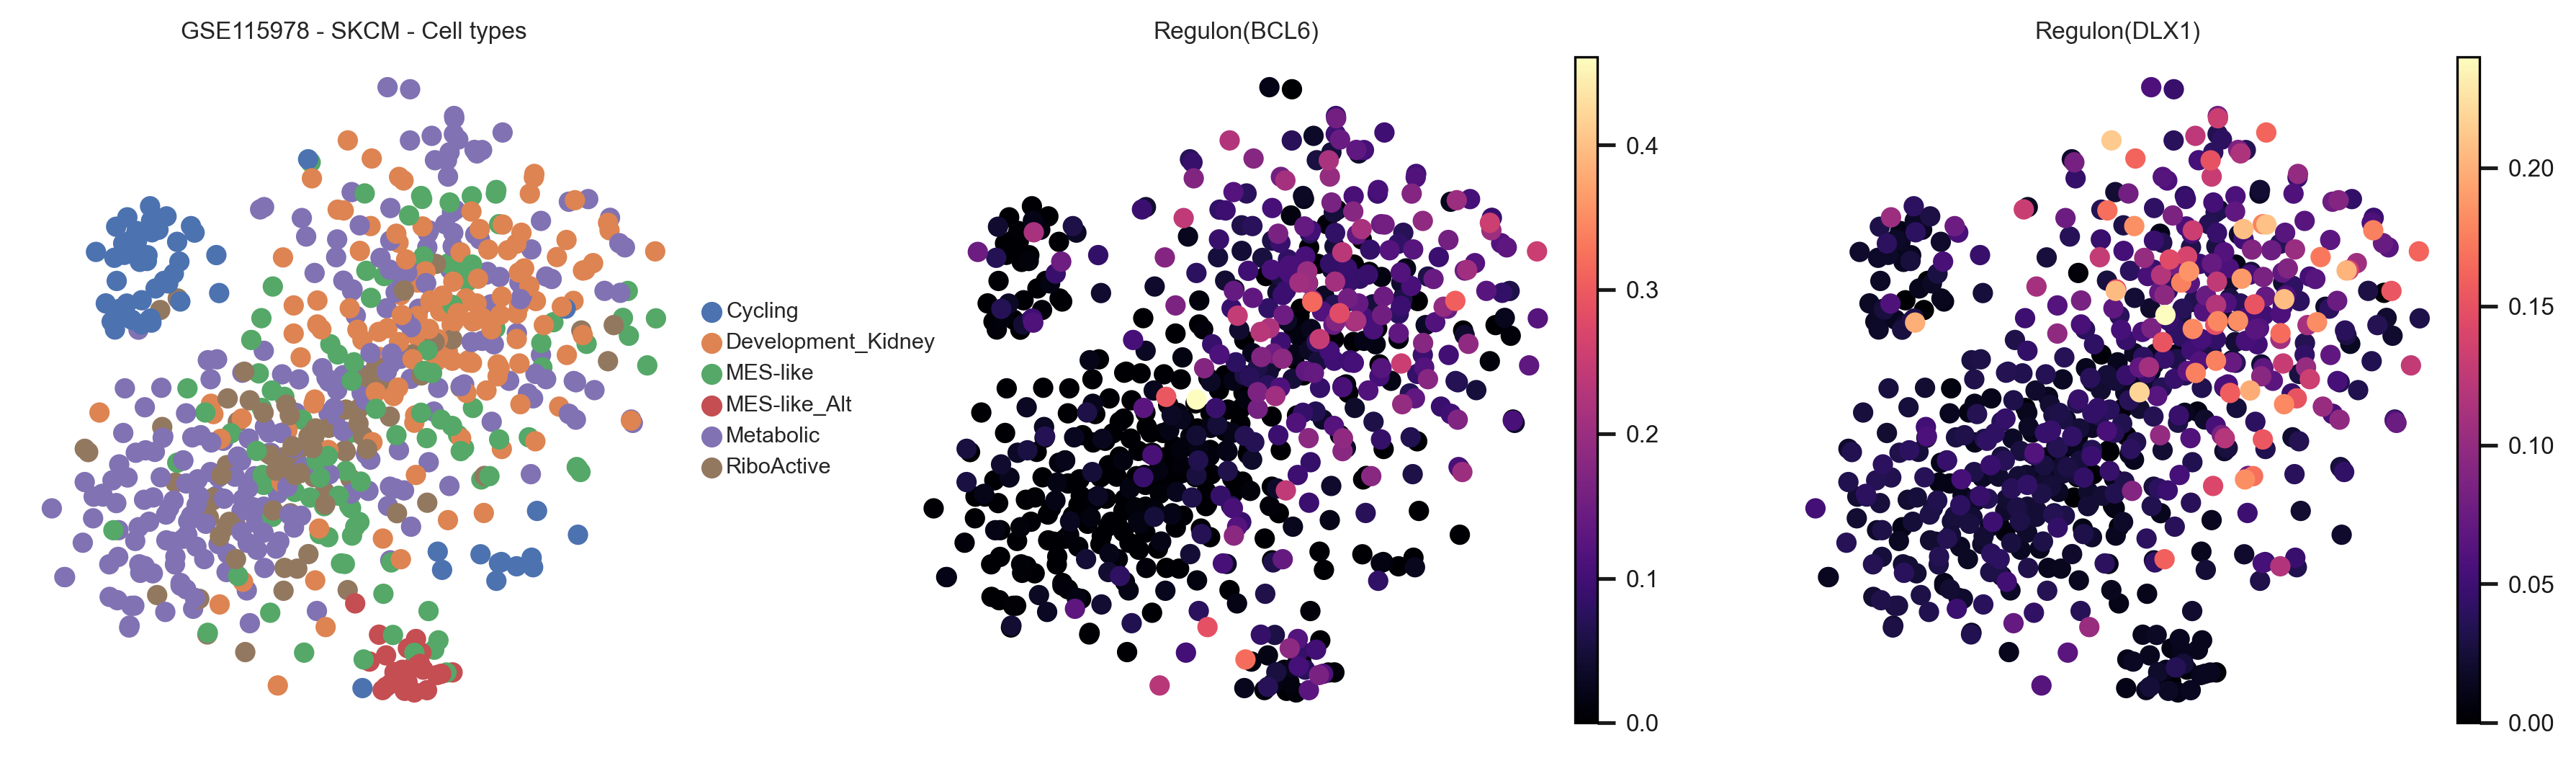

In [332]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['cell_type', 'Regulon(BCL6)','Regulon(DLX1)'],
           title=['GSE115978 - SKCM - Cell types', 'Regulon(BCL6)', 'Regulon(DLX1)'], ncols=4, use_raw=False,
          save=' - GSE115978 - rss_gene.svg', palette=COLORS, cmap='magma')

In [ ]:
## Convert database names for motifs (from step2-3, O2)
## No longer needed after updating derive_regulons function
df_motifs=pd.read_csv(MOTIFS_FNAME, header=None)
df_motifs=df_motifs.replace(to_replace="hg19__refseq-r80__500bp_up_and_100bp_down_tss.genes_vs_motifs.rankings", 
                            value="hg19-500bp-upstream-10species.mc9nr", regex=True)

df_motifs=df_motifs.replace(to_replace="hg19__refseq-r80__10kb_up_and_100bp_down_tss.genes_vs_motifs.rankings", 
                            value="hg19-tss-centered-10kb-10species.mc9nr", regex=True)
df_motifs.to_csv(RESULTS_FOLDERNAME +'step2_output/EditDB_{}_scenic_step2_output.csv'.format(ANALYSIS_NAME), 
                 header=False, index=False)